In [347]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [348]:
df = pd.read_csv('gas_data.csv', sep=";", names=['Topic Pulse', 'TimeStamp'], header=None)
df[['Topic','Pulse']] = df['Topic Pulse'].str.split(' ',expand=True)
df.drop(columns = ['Topic Pulse', 'Topic'], inplace=True)
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# Remove milli seconds
df['TimeStamp'] = df['TimeStamp'].dt.to_period('s').dt.to_timestamp()
df['Pulse'] = pd.to_numeric(df['Pulse'])
df.head()


,TimeStamp,Pulse
0,2024-09-26 21:38:00,0
1,2024-09-26 23:12:03,1
2,2024-09-26 23:12:41,2
3,2024-09-26 23:13:21,3
4,2024-09-26 23:58:34,4


In [349]:
df_r = pd.read_csv('gas_references.csv', sep=";", names=['Consumption', 'TimeStamp'], header=None)
df_r['TimeStamp'] = pd.to_datetime(df_r['TimeStamp'])
df_r['Consumption'] = pd.to_numeric(df_r['Consumption'])
df_r.head()

,Consumption,TimeStamp
0,3345.71,2024-09-26 21:38:00
1,3346.89,2024-09-27 07:04:00
2,3347.20,2024-09-27 14:58:00
3,3347.28,2024-09-27 17:16:00
4,3349.73,2024-09-28 15:10:00


# Plot pulse activity per hour

In [350]:
df['DateHour'] = df['TimeStamp'].dt.to_period('h')
df['Hour'] = df['TimeStamp'].dt.hour
df.head()

,TimeStamp,Pulse,DateHour,Hour
0,2024-09-26 21:38:00,0,2024-09-26 21:00,21
1,2024-09-26 23:12:03,1,2024-09-26 23:00,23
2,2024-09-26 23:12:41,2,2024-09-26 23:00,23
3,2024-09-26 23:13:21,3,2024-09-26 23:00,23
4,2024-09-26 23:58:34,4,2024-09-26 23:00,23


Text(0, 0.5, '# Pulses')

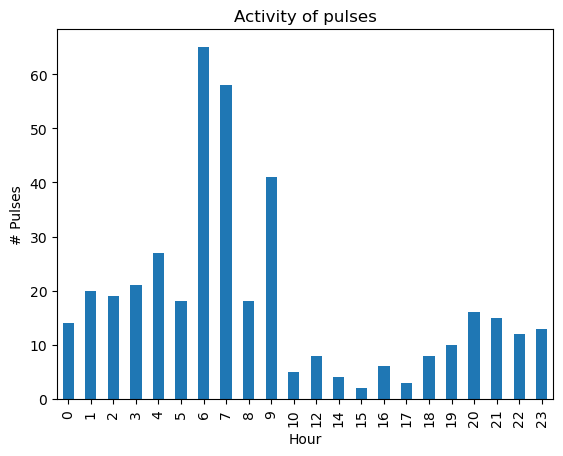

In [351]:
group = 'Hour' # datehour
activity = df.groupby([group])[group].count()
ax = activity.plot.bar(rot=90, title='Activity of pulses')
ax.set_ylabel("# Pulses")

# Consumption as function of pulses

In [352]:
# Find the matching pulse at time.
data = []
for i,r in df_r.iterrows():
    c = df.iloc[(df['TimeStamp']-r['TimeStamp']).abs().argsort()[0]]
    data.append([r['Consumption'], r['TimeStamp'], c['TimeStamp'], c['Pulse']])

df_ref = pd.DataFrame(data, columns=['Consumption', 'TimeStamp', 'PulseTimeStamp', 'Pulse'])
df_ref.set_index('Pulse', inplace=True)
df_ref

,Consumption,TimeStamp,PulseTimeStamp
Pulse,,,
0,3345.71,2024-09-26 21:38:00,2024-09-26 21:38:00
118,3346.89,2024-09-27 07:04:00,2024-09-27 07:00:32
150,3347.20,2024-09-27 14:58:00,2024-09-27 15:58:59
158,3347.28,2024-09-27 17:16:00,2024-09-27 17:37:04
402,3349.73,2024-09-28 15:10:00,2024-09-28 14:27:01


Text(0, 0.5, 'Gas [m3]')

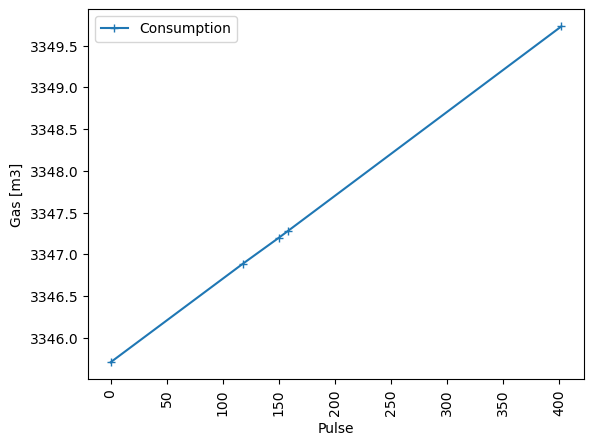

In [353]:
ax = df_ref.plot.line(y='Consumption', style='+-', rot=90)
ax.set_ylabel("Gas [m3]")

In [354]:
def estimate_coef(df, y='Consumption'):
  # number of observations/points
  n = len(df)

  # mean of x and y vector
  m_x = df.index.values.mean()
  m_y = df[y].mean()

  # calculating cross-deviation and deviation about x
  SS_xy = sum(df[y]*df.index) - n*m_y*m_x
  SS_xx = sum(df.index*df.index) - n*m_x*m_x

  # calculating regression coefficients
  #  f(x) = a*x + b
  a = SS_xy / SS_xx
  b = m_y - a*m_x

  return (a, b)

a, b = estimate_coef(df_ref)
print(f"Slope consumption per pulse is: {a:0.3f}")
print(f"Initial consumption is: {b:0.3f}")

Slope consumption per pulse is: 0.010
Initial consumption is: 3345.706


In [355]:
df_calc = df_ref[['Consumption']]
# Model: 0.01 m3 gas per pulse
df_calc['calc']= df_calc.index*0.01 + df_ref['Consumption'].values[0]
df_calc

,Consumption,calc
Pulse,,
0,3345.71,3345.71
118,3346.89,3346.89
150,3347.20,3347.21
158,3347.28,3347.29
402,3349.73,3349.73


<Axes: xlabel='Pulse'>

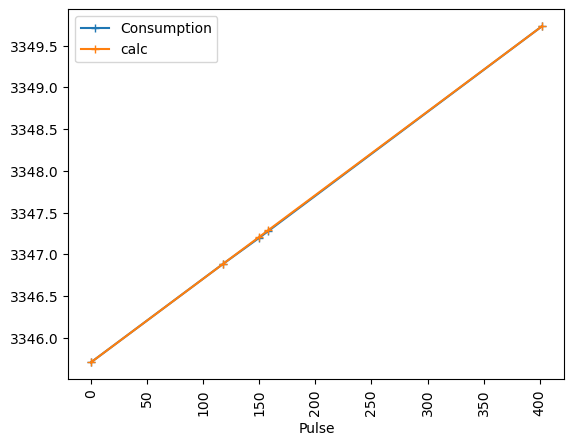

In [356]:
df_calc.plot.line(style='+-', rot=90)